In [411]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from __future__ import division

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# in the interest of code readability, grids are not flattened

In [437]:
def animate(L, T, J, nsteps, nper_step, title, 
            rs=np.random.RandomState(seed=None)):
    '''
    animates the evolution of a 2D XY grid based on input parameters
    using the metropolis algorithm.
    
    method:
    (1) initializes a grid at T=\infty and computes the H_mtx and H
    (2) initalizes the quiver plotting environment
    (3) calls animation.FuncAnimation() for nsteps number of times (each
        time the update_anim() helper function is called)
    
    since this is an animation code, the metropolis algorithm updates 
    the configuration environment nsteps*nper_step number of times, but
    the animation itself only updates after each nstep.
    
    update_anim() updates the grid 'nper_step' number of times before
    the quiver plotting environment is updated for the animation.
    
    this animation code was adapted from zhevnerchuk (github)
    '''
    grid = rs.rand(*(L,L))
    H_mtx = init_H_matrix(grid, J)
    H = np.sum(H_mtx)/2
    H_vals = [H]
    
    f, ax = plt.subplots(1,1)
    f.set_size_inches(10,8)
    ax.set_xlim(-1,L)
    ax.set_ylim(-1,L)

    X = np.array([[x for x in range(L)] for x in range(L)])
    Y = np.array([[y for x in range(L)] for y in range(L)])
    U = np.cos(2*np.pi*grid)
    V = np.sin(2*np.pi*grid)

    colors = []
    [colors.append(np.abs(H_mtx[i,j])) for i,j in zip(range(L), range(L))]

    Q = ax.quiver(X, Y, U, V, colors, units='inches')

    ani = animation.FuncAnimation(f, update_anim, frames=nsteps, 
                                  fargs=(Q, nper_step, grid, J, H_mtx, H, T, rs),
                                  interval=10)

    ani.save(title, codec="libx264")


def get_delta_H(grid, J, change_pos, new_val):
    '''
    the delta_H between the old grid configuration and the proposed new
    grid configuration is computed and returned.
    
    method:
    (1) look at the 4 neighboring points of the chosen changing spin
        site
    (2) at each site, evaluate the hamiltonian difference from the random
        new_val and then subtract off the hamiltonian difference from the
        original old_val
    (3) add up each of the 4 terms obtained from (2)
    (4) return the negative of (3) (and multiply the term by -J if that 
        wasn't done in step (2)). this is the delta_H returned.
    
    args:
    - grid is the lattice
    - J is the coupling strength
    - change_pos is the randomly chosen position on the lattice grid at
      which the spin would be changing
    - new_val is the new spin value to which the spin would be changing
      to
      
    returns:
    - delta_H
    - a dictionary with {key: value} entries of 
      {neighboring position coords: corresponding component of delta_H}
      (useful for update_H_matrix)
    '''
    delta_H_dict = {}
    
    L = grid.shape[0]
    old_val = grid[change_pos]
    pos_list = list(change_pos)
    
    for i in range(len(change_pos)):
        pos_list[i] = (pos_list[i]+1) % L 
        delta_H_dict[tuple(pos_list)] = \
                (np.cos(2*np.pi * (grid[tuple(pos_list)] - new_val)) 
                 - np.cos(2*np.pi * (grid[tuple(pos_list)] - old_val)))

        pos_list[i] = (pos_list[i]-2) % L
        delta_H_dict[tuple(pos_list)] = \
                (np.cos(2 * np.pi * (grid[tuple(pos_list)] - new_val)) 
                 - np.cos(2 * np.pi * (grid[tuple(pos_list)] - old_val)))

        pos_list[i] = (pos_list[i]+1) % L

    delta_H = np.sum(delta_H_dict.values())
    return -J * delta_H, delta_H_dict


def init_H_matrix(grid, J):
    '''
    creates and returns the initial hamiltonian matrix of the grid
    for simplicity, only works with a LxL 2D grid
    '''
    H_mtx = np.zeros(grid.shape)
    L = grid.shape[0]
    
    for i in range(L):
        for j in range(L): 
            H_mtx[i,j] = 0
            H_mtx[i,j] -= np.cos(2*np.pi * (grid[i,j] - grid[(i+1)%L,j]))
            H_mtx[i,j] -= np.cos(2*np.pi * (grid[i,j] - grid[(i-1)%L,j]))
            H_mtx[i,j] -= np.cos(2*np.pi * (grid[i,j] - grid[i,(j+1)%L]))
            H_mtx[i,j] -= np.cos(2*np.pi * (grid[i,j] - grid[i,(j-1)%L]))
        
    return J*H_mtx


def step(grid, J, H_mtx, H, T, rs, return_vals=False):
    '''
    steps through each iteration of the updating XY grid
    
    - change_pos is the lattice site chosen at random
    - new_val is the new spin value for the chosen change_pos site
    - the changing is accepted with probability exp(-delta_H/T)
      where delta_H is the change in the Hamiltonian from the original
      to the proposed new spin at the site
      
    if return_vals=True, returns grid,H_mtx (for the run_XY function where
    the grid evolution is not animated)
    '''
    change_pos = tuple([rs.randint(z) for z in grid.shape])
    new_val = rs.rand()
    delta_H, delta_H_dict = get_delta_H(grid, J, change_pos, new_val)
    
    if ((delta_H <= 0) or 
        ((delta_H > 0) and (rs.rand() < np.exp(-delta_H / T)))):
        H_mtx = update_H_matrix(H_mtx, J, delta_H_dict, change_pos)
        grid[change_pos] = new_val
        H += delta_H

    if return_vals:
        return grid, H_mtx, H


def update_anim(framenum, Q, nsteps, grid, J, H_mtx, H, T, rs, colored=True):
    '''
    updates the grid with the quiver arrows pivoting in the direction of their
    spin the colors represent 
    
    helper function for animation.FuncAnimation
    '''    
    for n in range(nsteps):
        grid, H_mtx, _ = step(grid, J, H_mtx, H, T, rs, return_vals=True)
    
    U = np.cos(2*np.pi*grid)
    V = np.sin(2*np.pi*grid)
    colors = np.abs(H_mtx.flatten('F'))
    
    if colored:
        Q.set_UVC(U,V,colors)
    else:
        Q.set_UVC(U,V)
    
    return Q,


def update_H_matrix(H_mtx, J, delta_H_dict, change_pos):
    '''
    updates and returns the H_mtx depending on values from
    the get_delta_H() function
    
    method:
    (1) iterates through the keys (positions of the neighbors) and 
        values (components of delta_H change) in delta_H_dict
    (2) for each iteration, subtracts off the delta_H component from
        the neighbor as well as the change_pos position itself
    (3) returns the result
    
    args:
    - H_mtx is the hamiltonian matrix
    - J is the coupling strength
    - delta_H_dict is a dictionary returned from the fn get_delta_H()
    - change_pos is the randomly chosen position on the lattice grid at
      which the spin is changing
      
    returns:
    - the new updated hamiltonian matrix
    '''    
    for key in delta_H_dict.iterkeys():
        H_mtx[key] -= delta_H_dict[key]*J
        H_mtx[change_pos] -= delta_H_dict[key]*J
        
    return H_mtx

    
def run_XY(L, T, J, nsteps, nper_step, title, rs=np.random.RandomState(seed=None), 
           colored=True, returnplot=False):
    '''
    runs the XY model simulation without animation. 
    
    method:
    (1) initializes a grid at T=\infty and computes the H_mtx and H
    (2) initalizes the quiver plotting environment
    (3) calls update_anim() for framenum number of times (refer to the animate()
        function as to why this is the call behavior)
    
    whether the arrows are colored or not depends on the 'colored' parameter
    
    if returplot==True, the quiver plot is returned (and can be reproduced outside
    of this function by accessing its q values, e.g., {q.X, q.Y, q.U, q.V}).
    '''
    grid = rs.rand(*(L,L))
    H_mtx = init_H_matrix(grid, J)
    H = np.sum(H_mtx)/2
    H_vals = [H]
    
    f, ax = plt.subplots(1,1)
    f.set_size_inches(10,8)
    ax.set_xlim(-1,L)
    ax.set_ylim(-1,L)

    X = np.array([[x for x in range(L)] for x in range(L)])
    Y = np.array([[y for x in range(L)] for y in range(L)])
    U = np.cos(2*np.pi*grid)
    V = np.sin(2*np.pi*grid)

    if colored==True:
        colors = []
        [colors.append(np.abs(H_mtx[i,j])) for i,j in zip(range(L), range(L))]
        Q = ax.quiver(X, Y, U, V, colors, units='inches')
    elif colored=='Map':
        colors = np.arctan2(V,U)
        norm = Normalize()
        norm.autoscale(colors)
        
        Q = ax.quiver(X, Y, U, V, colors, units='inches',cmap=cm.coolwarm)
        sm = cm.ScalarMappable(cmap=cm.coolwarm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm)
    else:
        Q = ax.quiver(X, Y, U, V, units='inches')
    
    for framenum in range(nsteps+1):
        Q, = update_anim(framenum, Q, nper_step, grid, J, H_mtx, H, T, rs, 
                         colored=colored)
        
    if returnplot:
        return Q,

***

## Looking at bound vortices at T < T_c

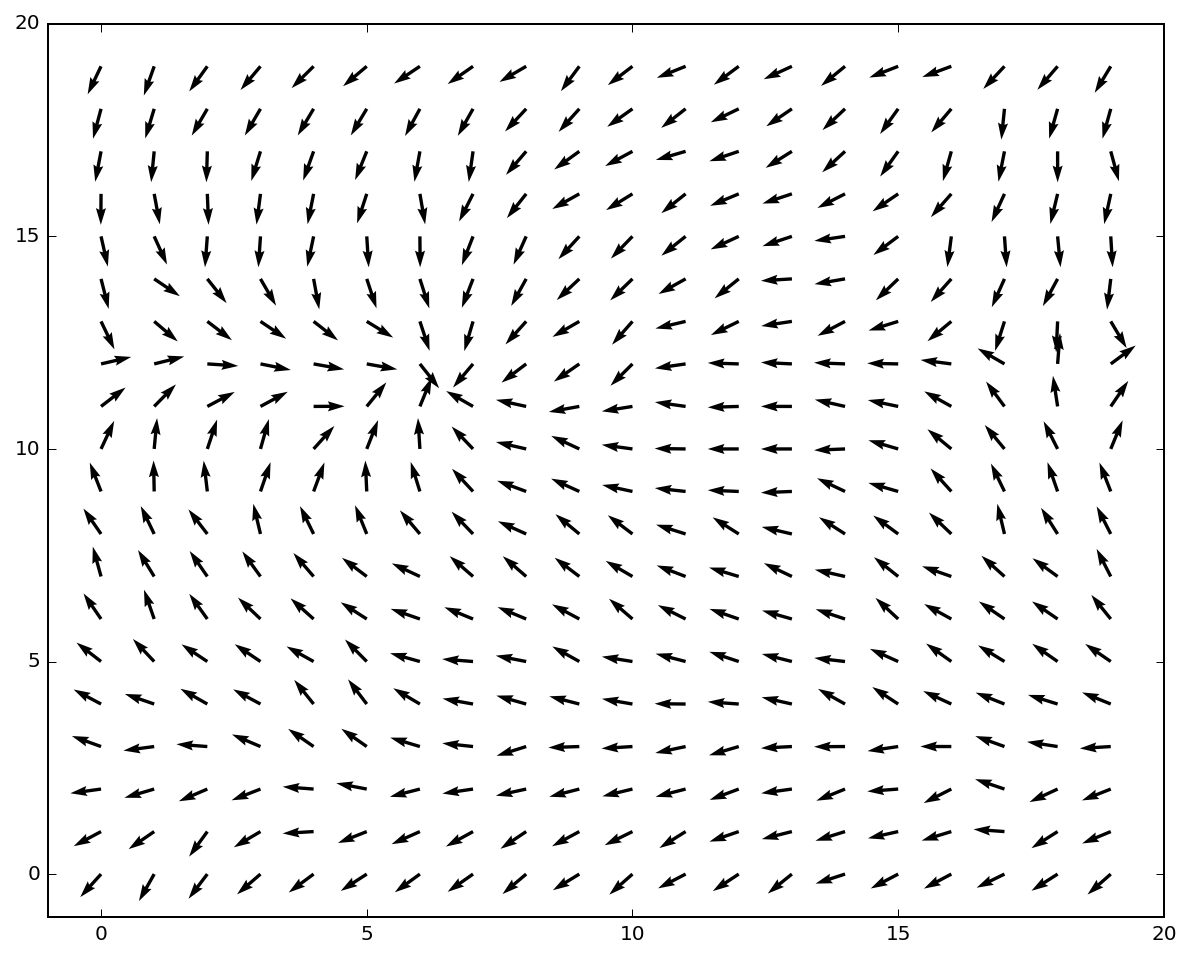

In [483]:
L = 20
T = 0.1 # = 1/beta
J = 1
nsteps = 5000
nper_step = 100
title=''

run_XY(L, T, J, nsteps, nper_step, title, rs=np.random.RandomState(seed=658976), 
       colored=False)
plt.savefig('vortices.pdf')

***

## Sanity checking evolution

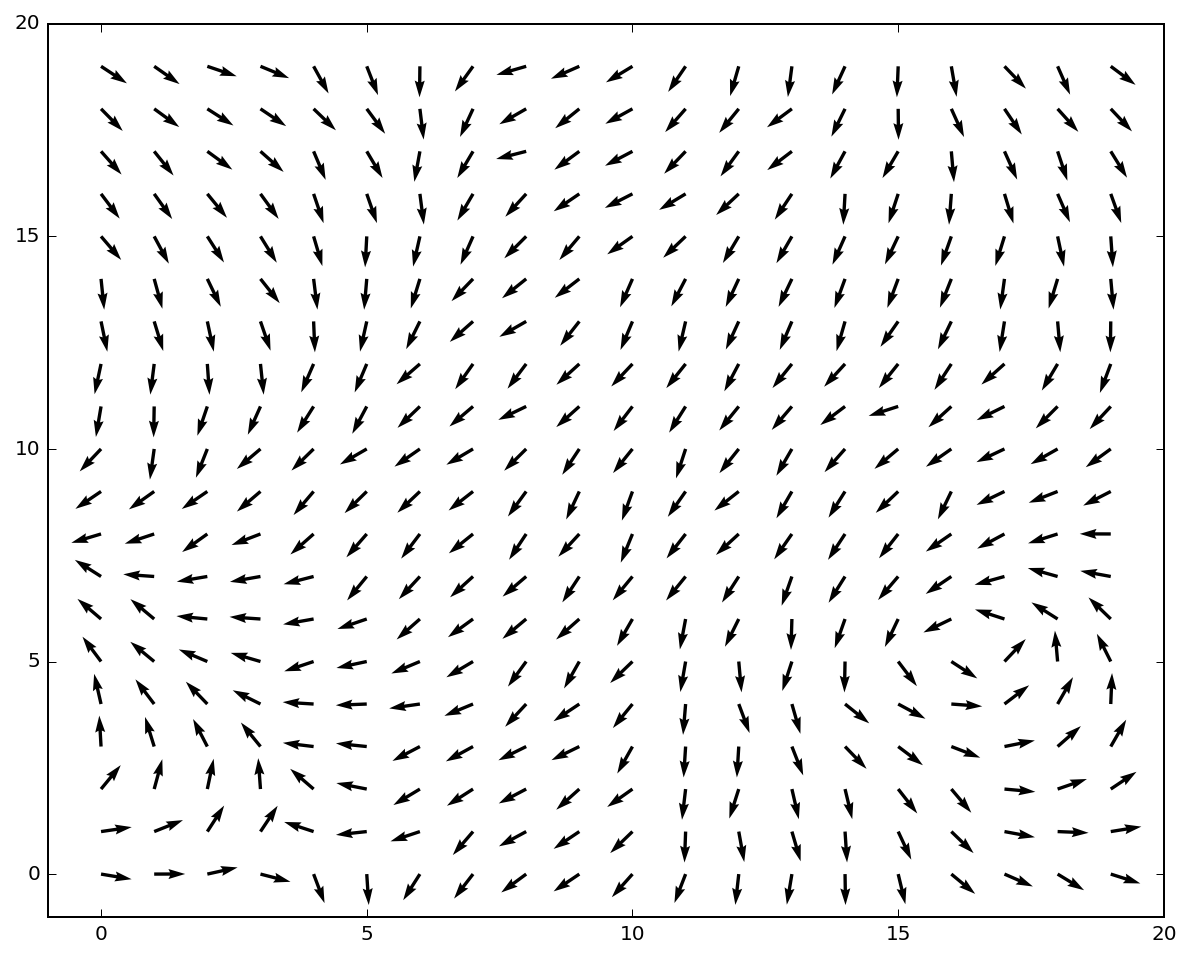

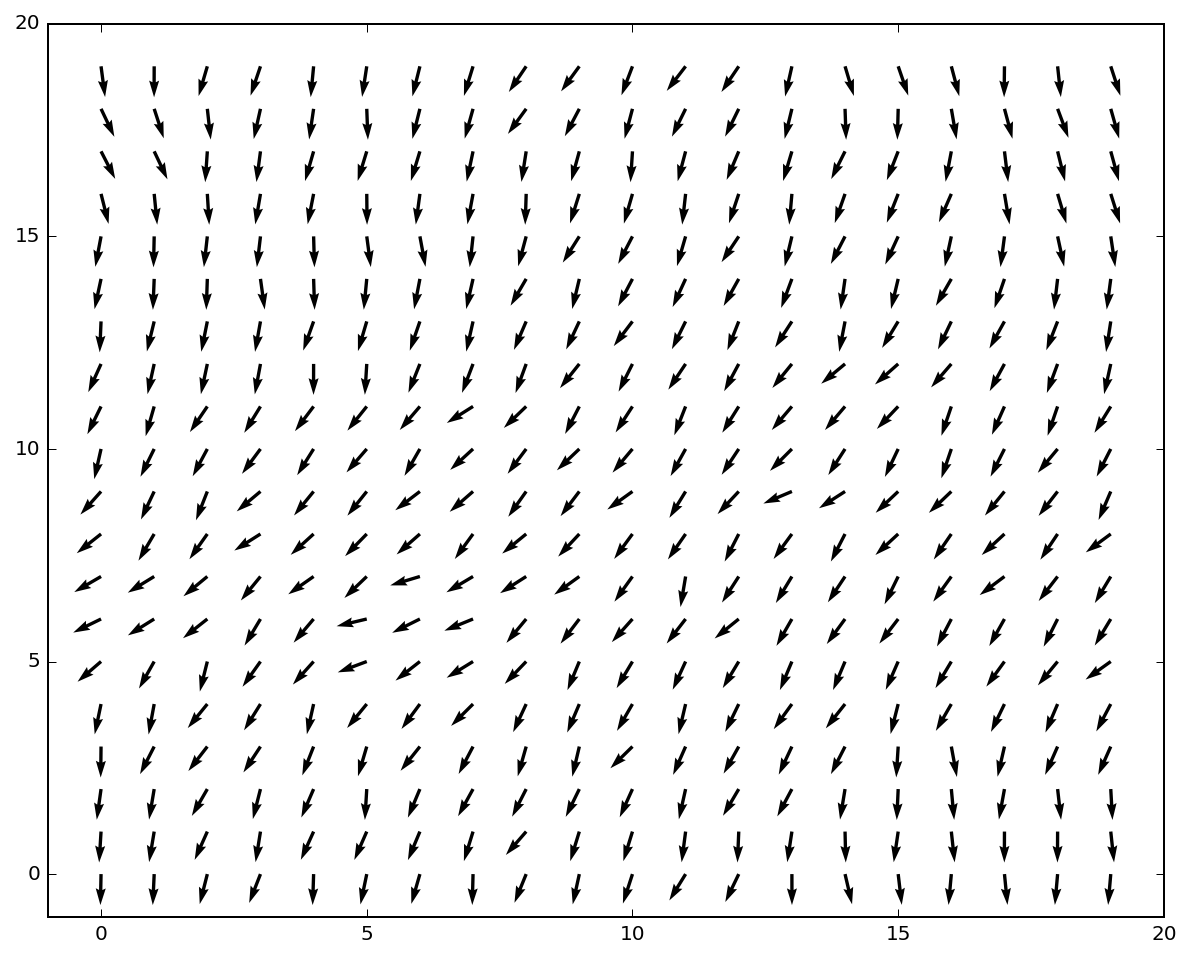

In [461]:
L = 20
T = 0.1 # = 1/beta
J = 1
nsteps = 1000
nper_step = 100
title=''

quiverq = np.array([])
nsteparr = [1000,3000]
nper_step=100
for ax, nsteps in zip(axarr, nsteparr):
    q, = run_XY(L, T, J, nsteps, nper_step, title, 
                rs=np.random.RandomState(seed=7675), colored=False, 
                returnplot=True)
    quiverq = np.append(quiverq, q)
plt.show()

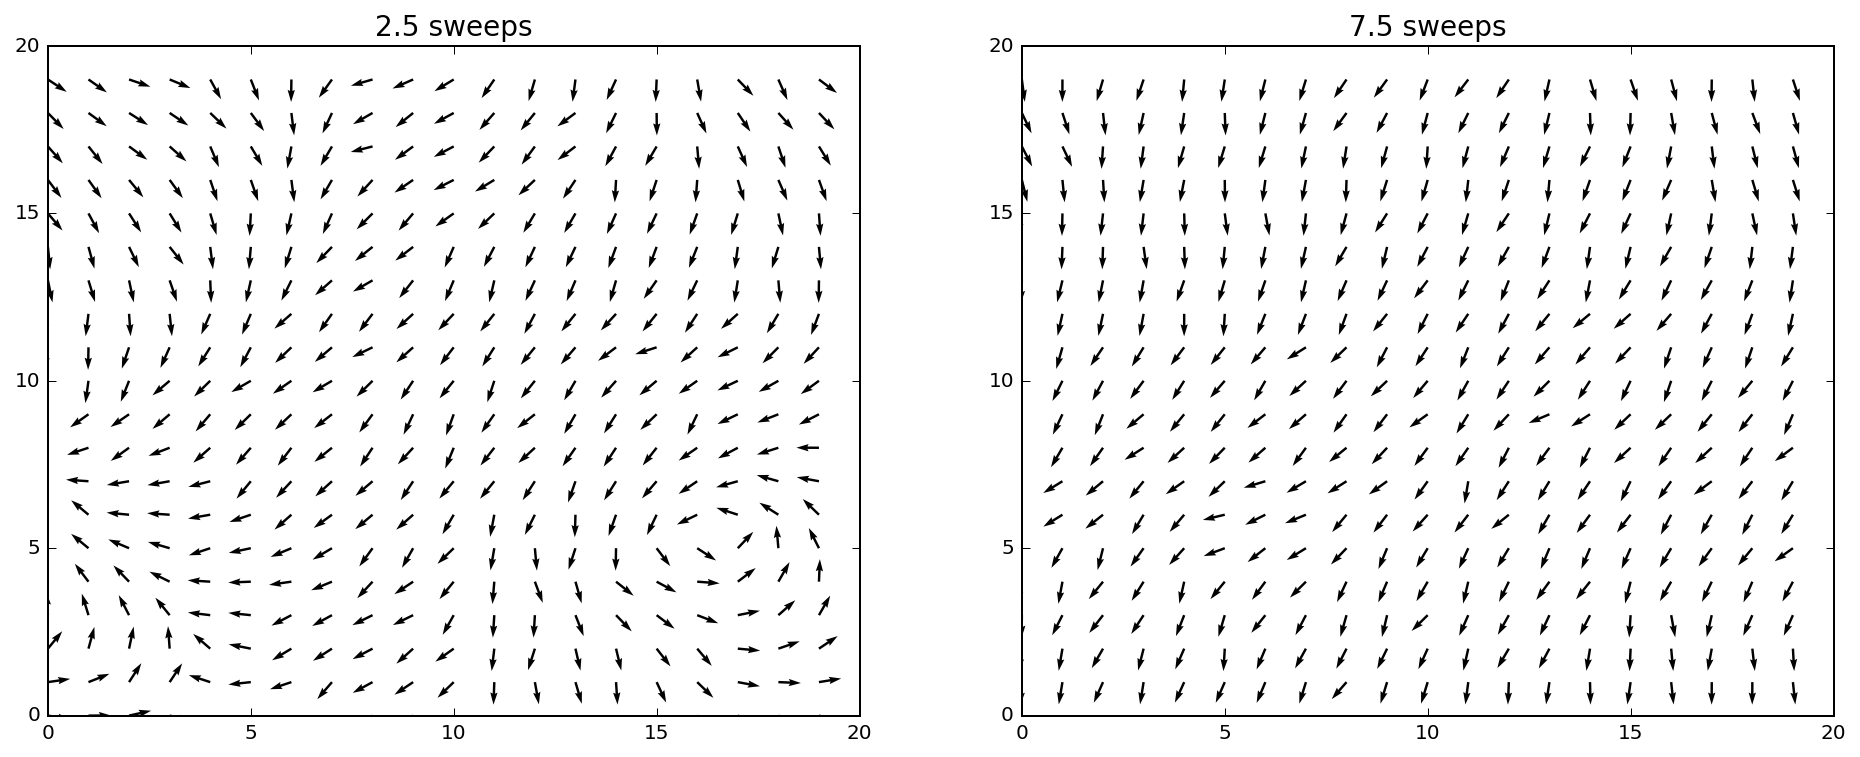

In [466]:
f, axarr = plt.subplots(1,2)
f.set_size_inches(16,6)
for ax, q, nsteps in zip(axarr, quiverq, nsteparr):
    ax.quiver(q.X, q.Y, q.U, q.V)
    ax.set_title(str(nsteps/L**2)+' sweeps', fontsize=14)
plt.savefig('Report/XYsanitycheck.pdf')

***

# Checking equilibration time

In [434]:
L=20
# grid = np.ones((L,L))
grid = np.random.rand(*(L,L))
H_mtx = init_H_matrix(grid, J)
H = np.sum(H_mtx)/2.0

T = 0.1

nsweep = 2000

# energy
energy_list = np.concatenate(([H], np.zeros(nsweep*L*L)))

# mag
mag = np.sum(grid)
mag_list = np.concatenate(([np.sqrt(np.sum(np.cos(grid))**2+np.sum(np.sin(grid))**2)],
                           np.zeros(nsweep*L*L)))

# evolution
for i in range(nsweep*L*L+1):
    if ((i+1) % 10000) == 0: print 'index',i
    grid, H_mtx, H = step(grid, J, H_mtx, H, T, rs, return_vals=True)

    # increment
    energy_list[i] = H
    mag_list[i] = np.sqrt(np.sum(np.cos(grid))**2+np.sum(np.sin(grid))**2)
    
mag_list = np.array(mag_list)/(L*L)

index 9999
index 19999
index 29999
index 39999
index 49999
index 59999
index 69999
index 79999
index 89999
index 99999
index 109999
index 119999
index 129999
index 139999
index 149999
index 159999
index 169999
index 179999
index 189999
index 199999
index 209999
index 219999
index 229999
index 239999
index 249999
index 259999
index 269999
index 279999
index 289999
index 299999
index 309999
index 319999
index 329999
index 339999
index 349999
index 359999
index 369999
index 379999
index 389999
index 399999
index 409999
index 419999
index 429999
index 439999
index 449999
index 459999
index 469999
index 479999
index 489999
index 499999
index 509999
index 519999
index 529999
index 539999
index 549999
index 559999
index 569999
index 579999
index 589999
index 599999
index 609999
index 619999
index 629999
index 639999
index 649999
index 659999
index 669999
index 679999
index 689999
index 699999
index 709999
index 719999
index 729999
index 739999
index 749999
index 759999
index 769999
index 7799

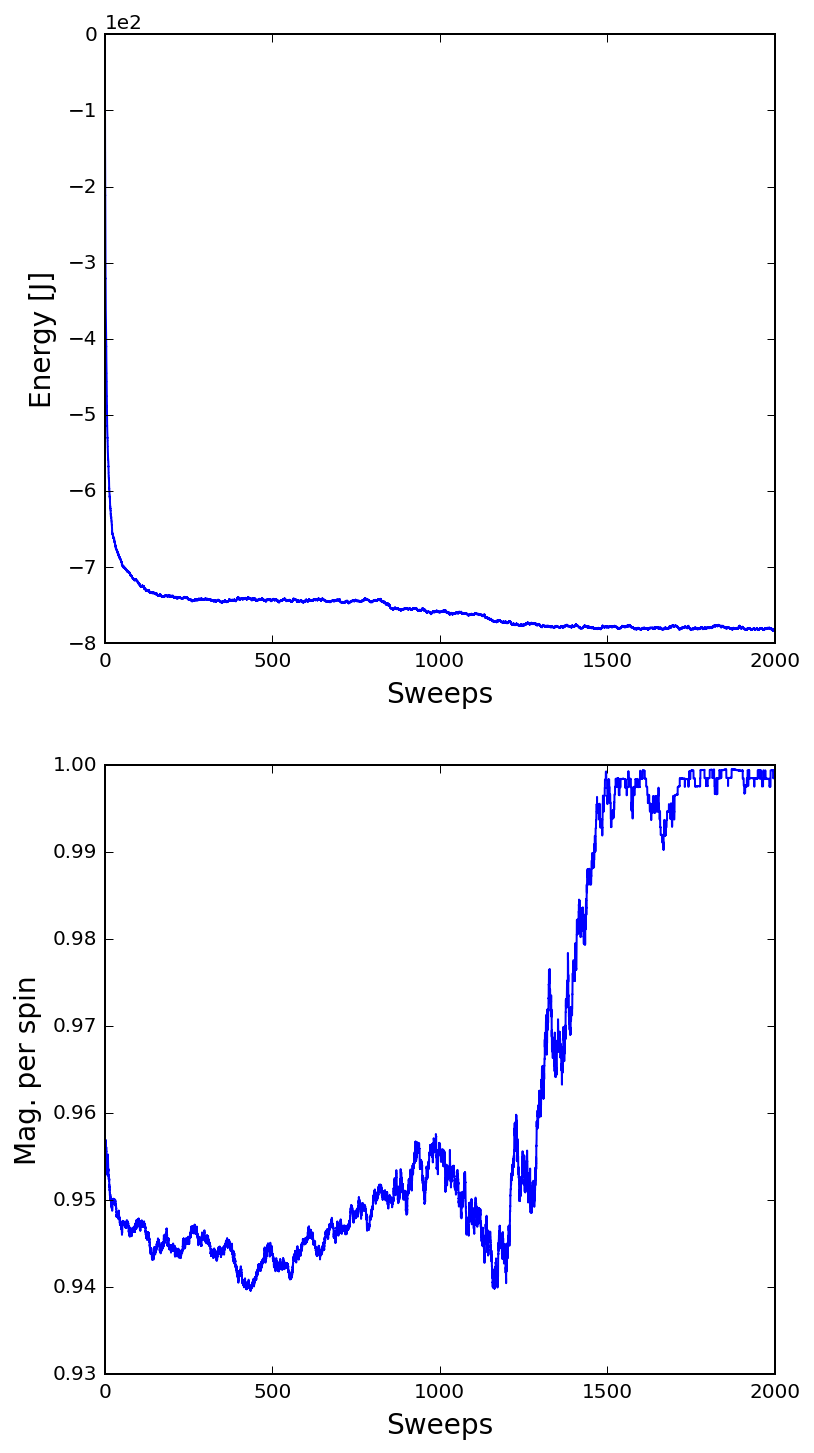

In [435]:
# plotting
x_axis = [i/(L*L) for i in range(nsweep*L*L+1)]
# x_axis = [i/(100*100) for i in range(2000*100*100+1)]

fig = plt.figure(figsize=(6, 12))

fig.add_subplot(2,1, 1)
plt.plot(x_axis,energy_list)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
plt.xlabel('Sweeps', fontsize=14)
plt.ylabel('Energy [J]', fontsize=14)

fig.add_subplot(2,1, 2)
plt.plot(x_axis, mag_list)
plt.tick_params(axis='both', which='mjor', labelsize=10)
plt.xlabel('Sweeps', fontsize=14)
plt.ylabel('Mag. per spin', fontsize=14)

plt.savefig('Report/Equilibration4.pdf', bbox_inches='tight')

***

## Obtaining measurements

In [327]:
temps = np.arange(0.8, 1.41, .01)

L=20
grid = np.ones((L,L))
H_mtx = init_H_matrix(grid, J)
H = np.sum(H_mtx)/2.0
H_vals= [H]

n_eq_coeff = 500 * L**2

energy = np.zeros(len(temps))
specific_heats = np.zeros(len(temps))
magnetization = np.zeros(len(temps))
susceptibility = np.zeros(len(temps))
for t, T in enumerate(temps):
    print 'T =', T, '(index', str(t)+')'

    # force the grid to equilibrate
    for nn in range(n_eq):
        grid, H_mtx, H = step(grid, J, H_mtx, H, T, rs, return_vals=True)

    counter = 0
    H0 = np.zeros(1000)
    # measurements to avg
    for mm in range(1000):
        for nn in range(L**2): # let the grid evolve for one sweep
            grid, H_mtx, H = step(grid, J, H_mtx, H, T, rs, return_vals=True)
        H0[mm] = H

    energy[t] = np.mean(H0)
    specific_heats[t] = np.var(H0)/T**2 

np.savez('XY_Observables', temps=temps, energy_per_spin=energy/L**2, 
         specific_heat_per_spin=specific_heats/L**2)

T = 0.8 (index 0)
T = 0.81 (index 1)
T = 0.82 (index 2)
T = 0.83 (index 3)
T = 0.84 (index 4)
T = 0.85 (index 5)
T = 0.86 (index 6)
T = 0.87 (index 7)
T = 0.88 (index 8)
T = 0.89 (index 9)
T = 0.9 (index 10)
T = 0.91 (index 11)
T = 0.92 (index 12)
T = 0.93 (index 13)
T = 0.94 (index 14)
T = 0.95 (index 15)
T = 0.96 (index 16)
T = 0.97 (index 17)
T = 0.98 (index 18)
T = 0.99 (index 19)
T = 1.0 (index 20)
T = 1.01 (index 21)
T = 1.02 (index 22)
T = 1.03 (index 23)
T = 1.04 (index 24)
T = 1.05 (index 25)
T = 1.06 (index 26)
T = 1.07 (index 27)
T = 1.08 (index 28)
T = 1.09 (index 29)
T = 1.1 (index 30)
T = 1.11 (index 31)
T = 1.12 (index 32)
T = 1.13 (index 33)
T = 1.14 (index 34)
T = 1.15 (index 35)
T = 1.16 (index 36)
T = 1.17 (index 37)
T = 1.18 (index 38)
T = 1.19 (index 39)
T = 1.2 (index 40)
T = 1.21 (index 41)
T = 1.22 (index 42)
T = 1.23 (index 43)
T = 1.24 (index 44)
T = 1.25 (index 45)
T = 1.26 (index 46)
T = 1.27 (index 47)
T = 1.28 (index 48)
T = 1.29 (index 49)
T = 1.3 (index 

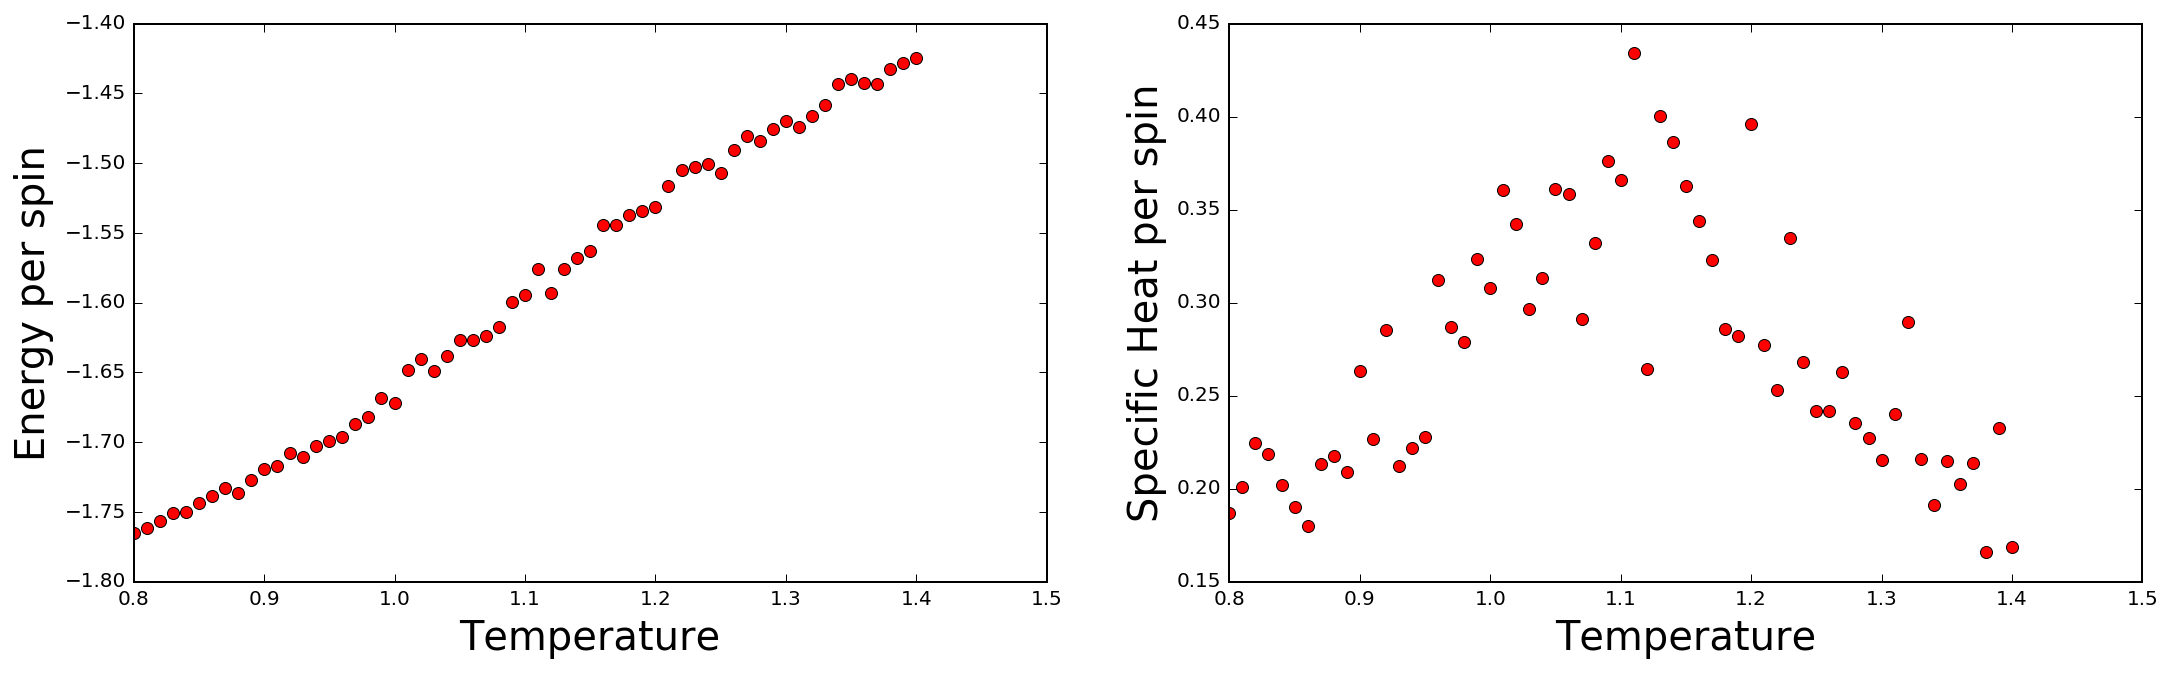

In [328]:
f, axarr = plt.subplots(1,2)
axes = np.ndarray.flatten(axarr)

axes[0].plot(temps, energy/L**2, 'ro')
axes[0].set_xlabel("Temperature", fontsize=20)
axes[0].set_ylabel("Energy per spin", fontsize=20)

axes[1].plot(temps, specific_heats/L**2, 'ro')
axes[1].set_xlabel("Temperature", fontsize=20)
axes[1].set_ylabel("Specific Heat per spin", fontsize=20)

f.set_size_inches(18,5)
plt.show()

### round 2

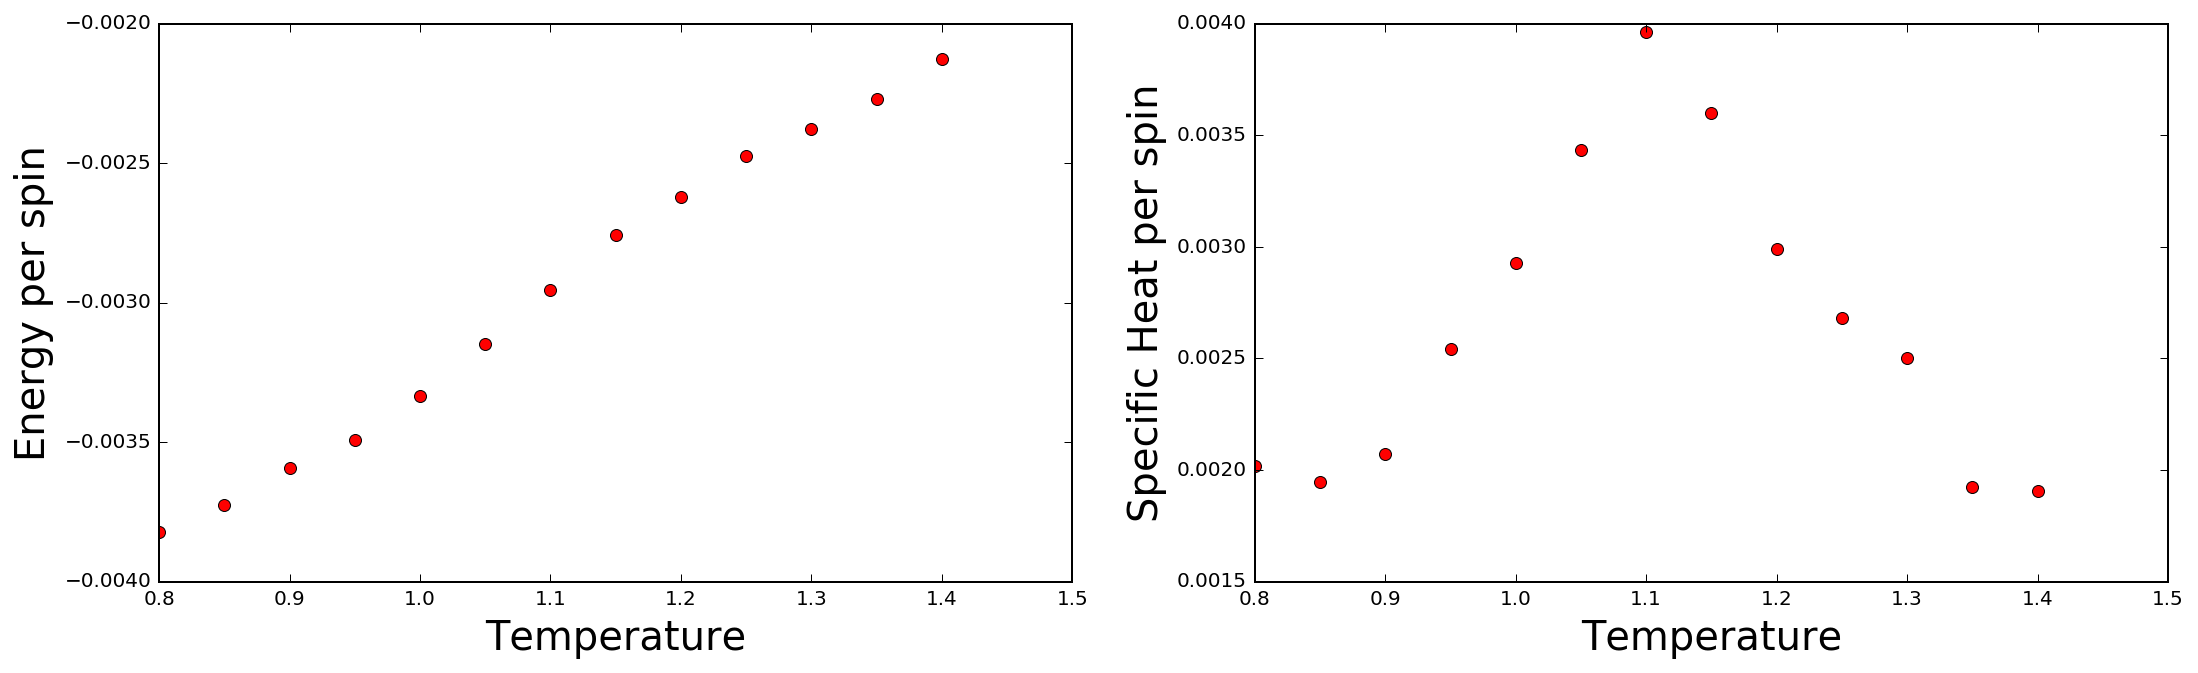

In [363]:
f, axarr = plt.subplots(1,2)
axes = np.ndarray.flatten(axarr)

axes[0].plot(temps, zz['energy_per_spin']/L**2, 'ro')
axes[0].set_xlabel("Temperature", fontsize=20)
axes[0].set_ylabel("Energy per spin", fontsize=20)

axes[1].plot(temps, zz['specific_heat_per_spin']/L**2, 'ro')
axes[1].set_xlabel("Temperature", fontsize=20)
axes[1].set_ylabel("Specific Heat per spin", fontsize=20)

f.set_size_inches(18,5)
plt.show()

### round 3

In [371]:
temps = np.arange(0.8, 1.42, .02)

L=20
rs=np.random.RandomState(seed=7675)
grid = rs.rand(*(L,L))
H_mtx = init_H_matrix(grid, J)
H = np.sum(H_mtx)/2.0
H_vals= [H]

n_eq_coeff = 1000 * L**2

energy = np.zeros(len(temps))
specific_heats = np.zeros(len(temps))
magnetization = np.zeros(len(temps))
susceptibility = np.zeros(len(temps))
for t, T in enumerate(temps):
    print 'T =', T, '(index', str(t)+')'

    # force the grid to equilibrate
    for nn in range(n_eq):
        grid, H_mtx, H = step(grid, J, H_mtx, H, T, rs, return_vals=True)

    counter = 0
    H0 = np.zeros(2500)
    M0 = np.zeros(2500)
    # measurements to avg
    for mm in range(2500):
        for nn in range(L**2): # let the grid evolve for one sweep
            grid, H_mtx, H = step(grid, J, H_mtx, H, T, rs, return_vals=True)
        H0[mm] = H
        M0[mm] = np.sqrt(np.sum(np.cos(grid))**2+np.sum(np.sin(grid))**2)

    energy[t] = np.mean(H0)
    specific_heats[t] = np.var(H0)/T**2
    magnetization[t] = np.mean(M0)
    susceptibility[t] = np.var(M0)/T**2

np.savez('XY_Observables5', temps=temps, energy_per_spin=energy/L**2, 
         specific_heat_per_spin=specific_heats/L**2,
        magnetization_per_spin=magnetization/L**2,
        susceptibility_per_spin=susceptibility/L**2)

T = 0.8 (index 0)
T = 0.82 (index 1)
T = 0.84 (index 2)
T = 0.86 (index 3)
T = 0.88 (index 4)
T = 0.9 (index 5)
T = 0.92 (index 6)
T = 0.94 (index 7)
T = 0.96 (index 8)
T = 0.98 (index 9)
T = 1.0 (index 10)
T = 1.02 (index 11)
T = 1.04 (index 12)
T = 1.06 (index 13)
T = 1.08 (index 14)
T = 1.1 (index 15)
T = 1.12 (index 16)
T = 1.14 (index 17)
T = 1.16 (index 18)
T = 1.18 (index 19)
T = 1.2 (index 20)
T = 1.22 (index 21)
T = 1.24 (index 22)
T = 1.26 (index 23)
T = 1.28 (index 24)
T = 1.3 (index 25)
T = 1.32 (index 26)
T = 1.34 (index 27)
T = 1.36 (index 28)
T = 1.38 (index 29)
T = 1.4 (index 30)


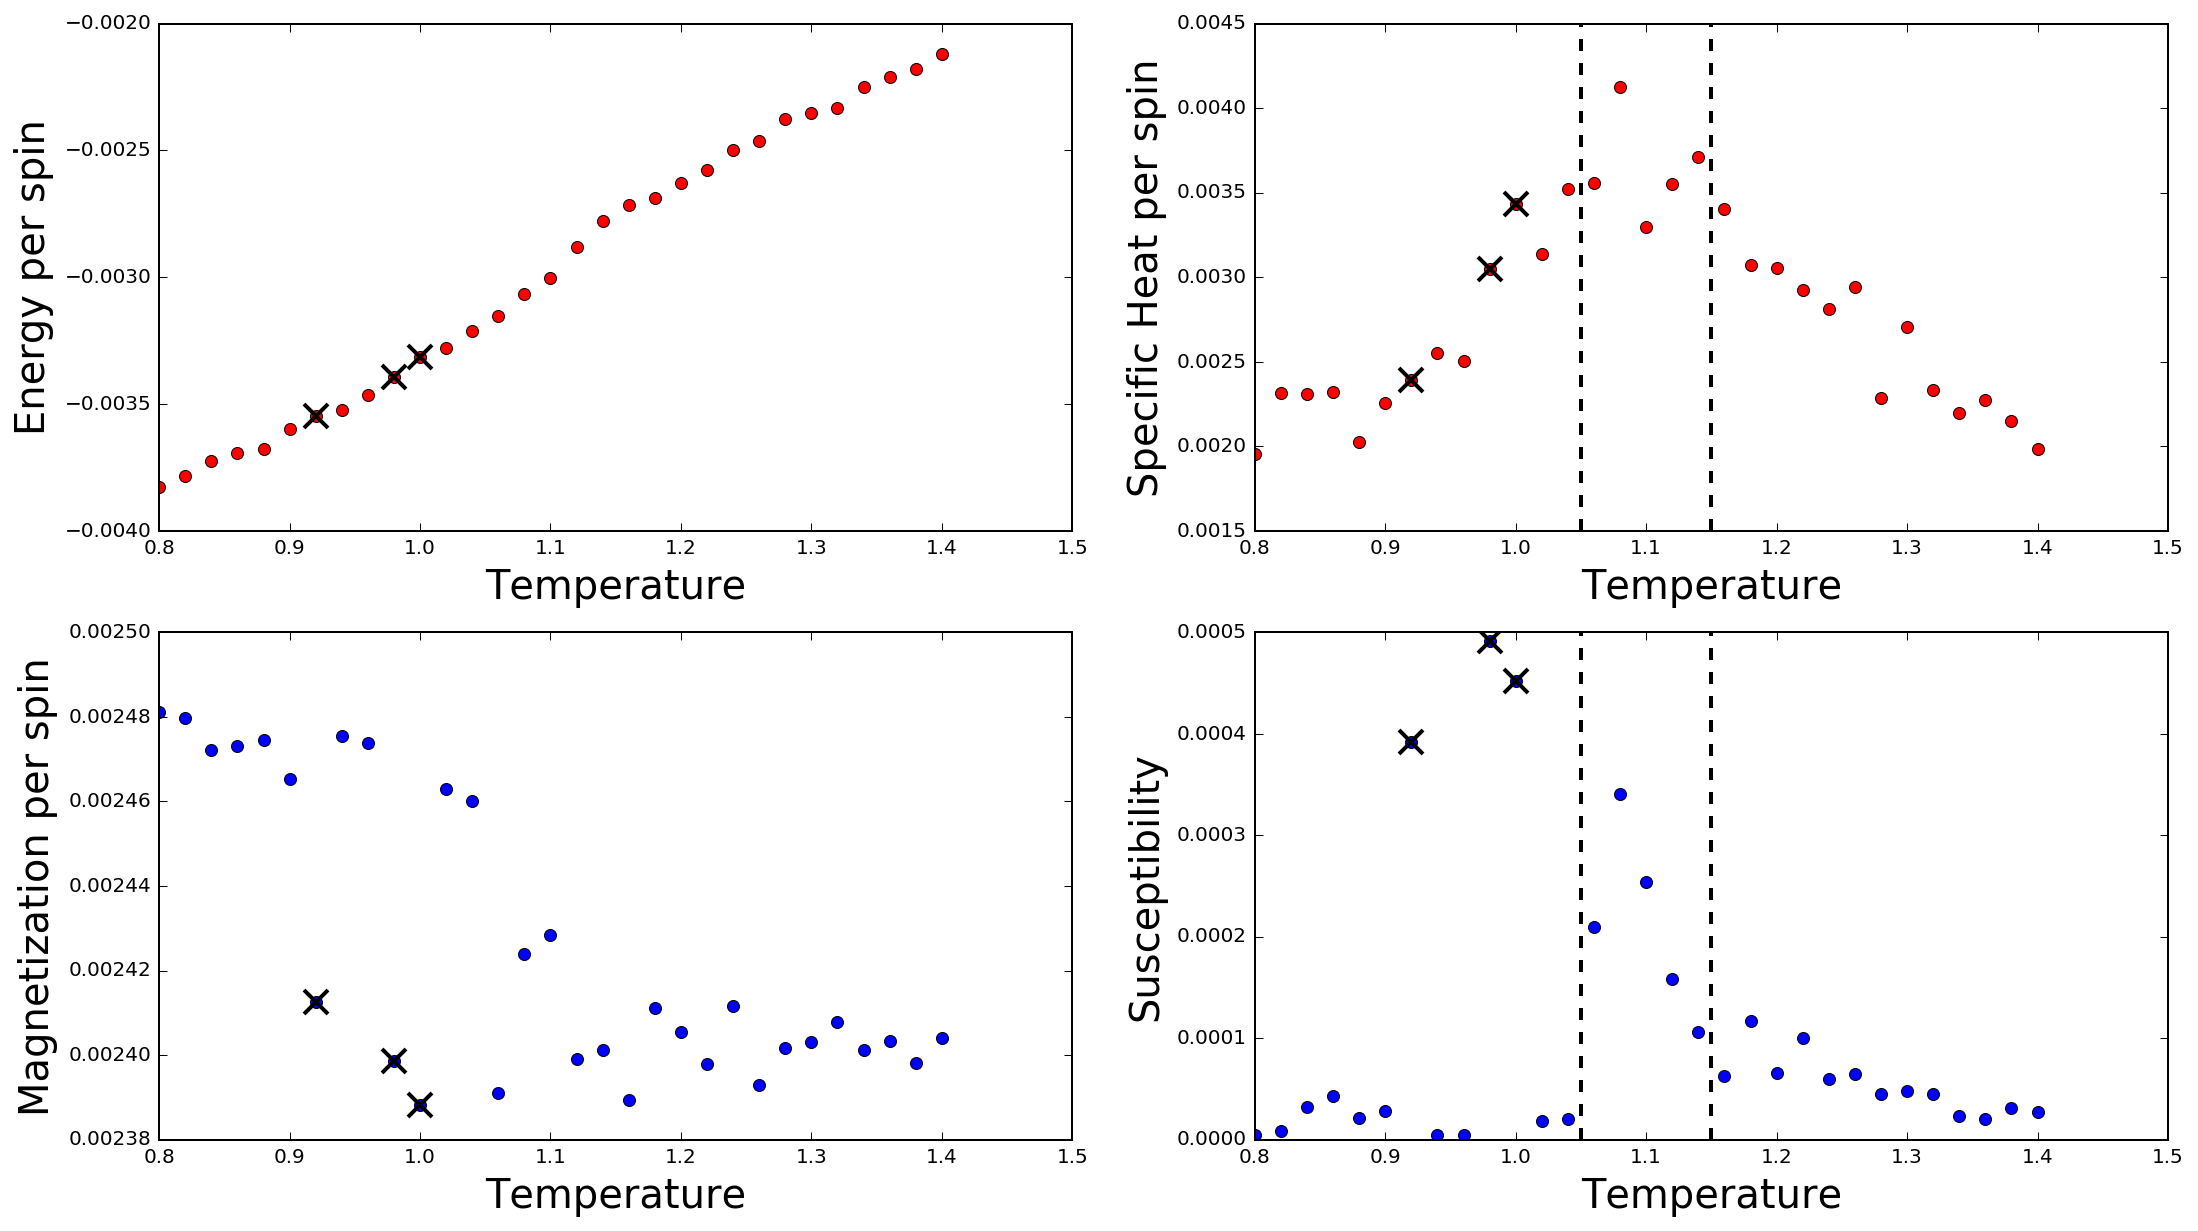

In [481]:
z = np.load('XY_Observables5.npz')
energy = z['energy_per_spin']
specific_heats = z['specific_heat_per_spin']
magnetization = z['magnetization_per_spin']
susceptibility = z['susceptibility_per_spin']

f, axarr = plt.subplots(2,2)
axes = np.ndarray.flatten(axarr)

axes[0].plot(temps, energy/L**2, 'ro')
axes[0].set_xlabel("Temperature", fontsize=20)
axes[0].set_ylabel("Energy per spin", fontsize=20)

axes[1].plot(temps, specific_heats/L**2, 'ro')
axes[1].set_xlabel("Temperature", fontsize=20)
axes[1].set_ylabel("Specific Heat per spin", fontsize=20)

axes[2].plot(temps, magnetization/L**2, 'bo')
axes[2].set_xlabel("Temperature", fontsize=20)
axes[2].set_ylabel("Magnetization per spin", fontsize=20)

axes[3].plot(temps, susceptibility/L**2, 'bo')
axes[3].set_xlabel("Temperature", fontsize=20)
axes[3].set_ylabel("Susceptibility", fontsize=20)


axes[0].plot(temps[big], energy[big]/L**2, 'kx', mew=2, markersize=12)
axes[1].plot(temps[big], specific_heats[big]/L**2, 'kx', mew=2, markersize=12)
axes[1].axvline(temps[13]-.01, color='k', ls='--', lw=2)
axes[1].axvline(temps[17]+.01, color='k', ls='--', lw=2)
axes[2].plot(temps[big], magnetization[big]/L**2, 'kx', mew=2, markersize=12)
axes[3].plot(temps[big], susceptibility[big]/L**2, 'kx', mew=2, markersize=12)
axes[3].axvline(temps[13]-.01, color='k', ls='--', lw=2)
axes[3].axvline(temps[17]+.01, color='k', ls='--', lw=2)

f.set_size_inches(18,10)
plt.savefig('Report/XYobservables.pdf')
plt.show()

***

# Playing around with different configurations

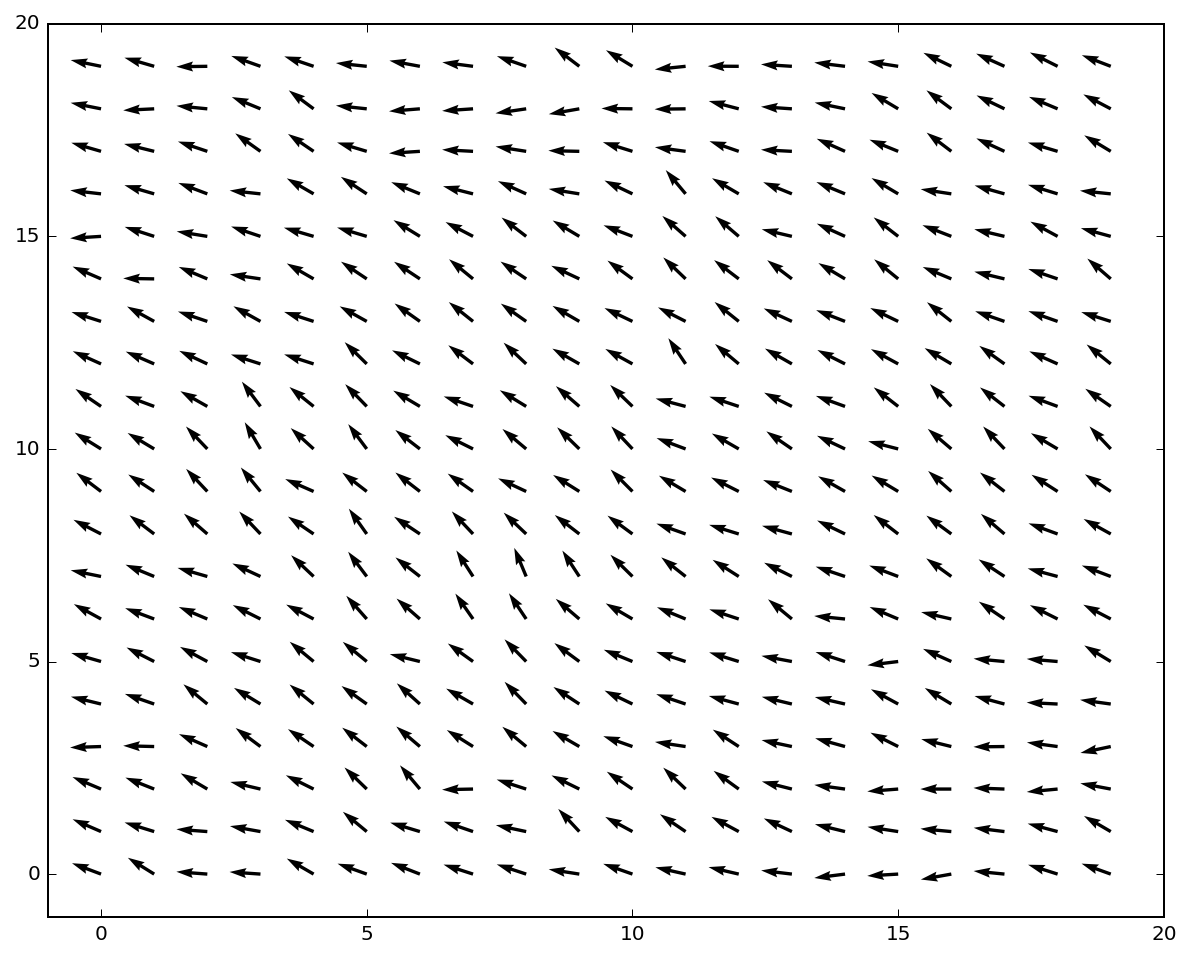

In [436]:
L = 20
T = 0.1 # = 1/beta
J = 1
nsteps = 3000
nper_step = 100
title=''

run_XY(L, T, J, nsteps, nper_step, title, rs=np.random.RandomState(seed=25), 
       colored=False)

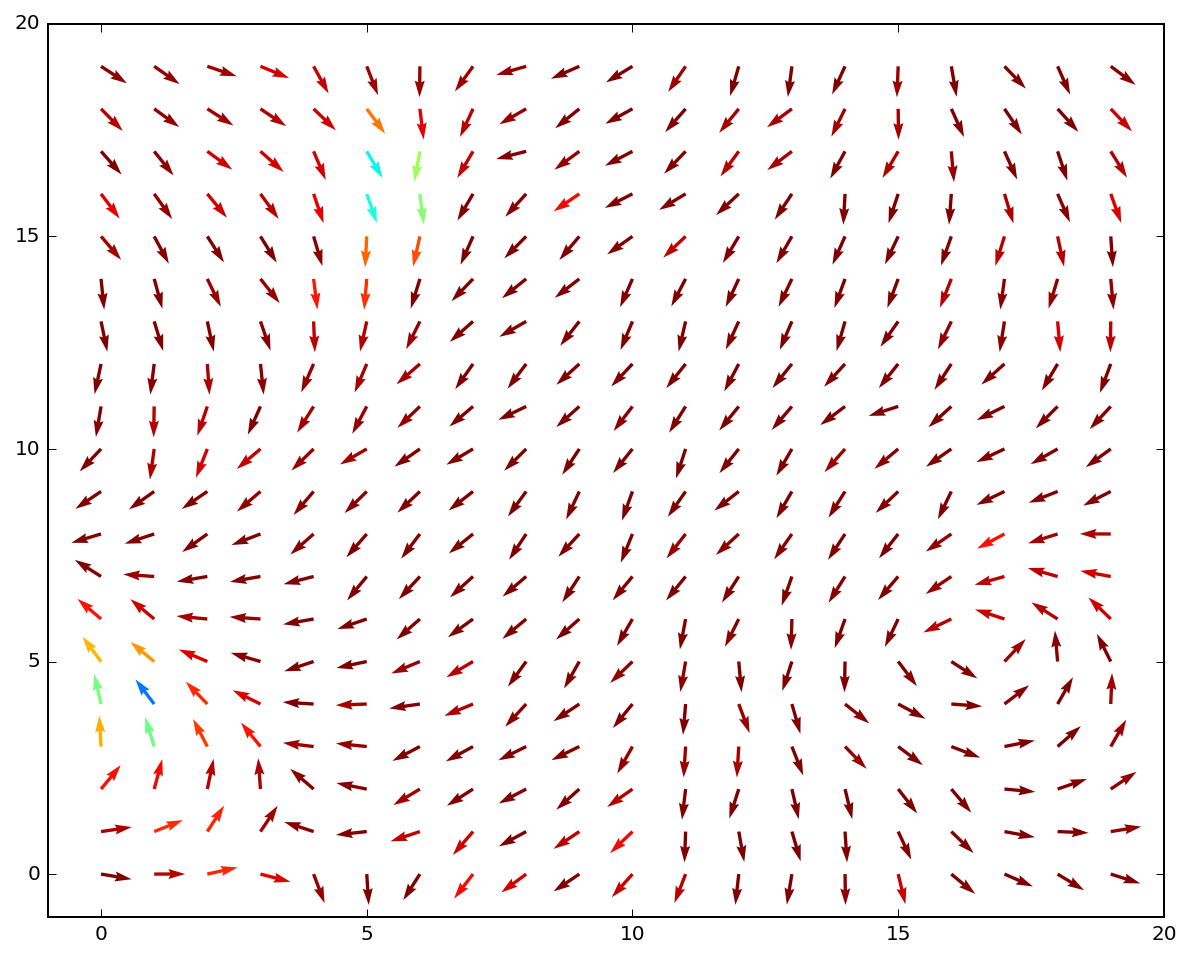

In [114]:
L = 20
T = 0.1 # = 1/beta
J = 1
nsteps = 1000
nper_step = 100
title = 'playing_around_6A.mp4'

animate(L, T, J, nsteps, nper_step, title, rs=np.random.RandomState(seed=7675))

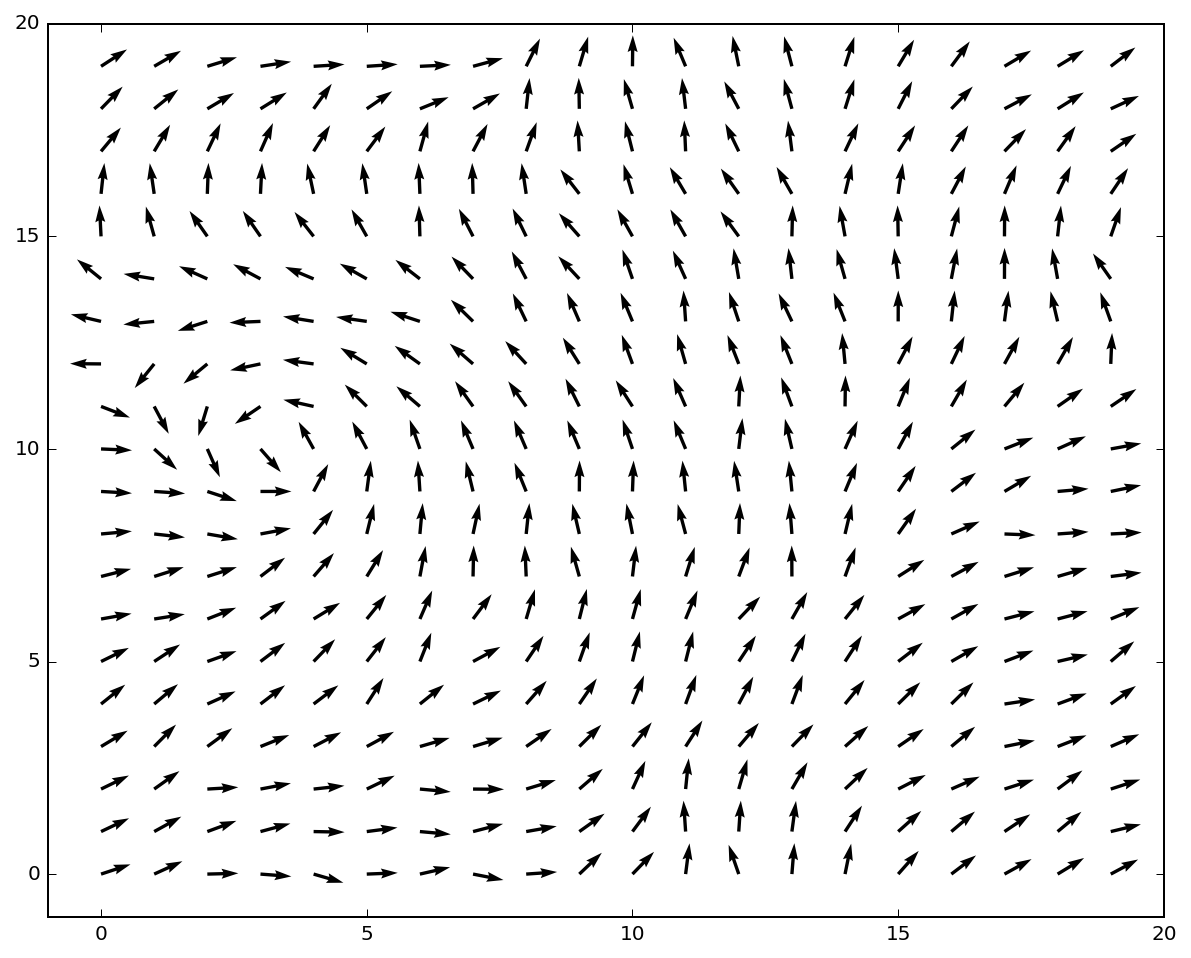

In [274]:
L = 20
T = 0.1 # = 1/beta
J = 1
nsteps = 1000
nper_step = 100
title=''

run_XY(L, T, J, nsteps, nper_step, title, rs=np.random.RandomState(seed=30),
       colored=False)